*Supporting textbook chapters for week 10: Chapters 10.1-10.4*

Week 10 topics:

* Random numbers
  * Tests for randomness
  * Generators
  * Random sampling from non-uniform distributions
* Monte Carlo integration
  * Why we use it
  * Hit-or-miss
  * Mean value
  * Importance sampling
  * Error estimation

# Random Numbers

## Intro to Random Numbers

Why we need random numbers:

* Sampling a domain
* Monte Carlo integration
* Monte Carlo simulations: including physical processes like diffusion, radioactive decay, Brownian motion
* Stochastic algorithms
* Cryptography (not covered here)

What is a useful random sequence of numbers?

* Follows some desired distribution
* Unpredictable on a number-by-number basis
* Fast to generate (we may need billions of them)
* Long period (we may need billions of them)
* Uncorrelated

Problems with *actually* random numbers:

* generally slow, expensive to generate,
* hard/impossible to reproduce for debugging
* Often hard to characterize underlying distribution

**Q:** How can a computer generate random numbers?

**A:** It can't, assuming it's a classical (not quantum) computer!

The classical computer can't do anything randomly. So there are 2 options:

* find physical process (e.g. quantum) that actually is random, have computer store info from that to provide a random number. e.g. https://qrng.anu.edu.au/
* Use an algorithm for generating a sequence of numbers that approximates the properties of random numbers. This is called a "Pseudorandom Number Generator" (PRNG) or a "Deterministic Random Bit Generator" (DRBG).

## Common Tests for Randomness

### Correlations

Simple pairwise correlations:
$$\epsilon(N, n) = \frac1N \sum_{i=1}^{N}x_i x_{i+n} - \mathrm E[x^2]$$

* $N =$ number of data points
* $n = $ correlation "distance"
* $\mathrm E[X]$, the expected value of $X$.

We want to avoid correlations between pairs of numbers.

Left: bad PRNG. right: Mersenne Twister. From Katzgrabber, "Random Numbers in Scientific Computing: an Introduction" (arXiv: 1005.4117)

![Mersenne](Mersenne.png)

### Other tests

 * Check the 'moments' of the random number sequences to ensure they have certain desired properties. $k^\text{th}$ moment of $\mu(N, k)$ (sequence of $N$ elements) : $\mu(N, k) = \mathrm E[x^k]$
 * Overlapping permutations. e.g. analyze orders of 5 consecutive random numbers. There are $5! (=5\times4\times\dots)$  possible permutations. They should occur with equal probability.

## Linear Congruential Generator

* Sequences produced by a PRNG seem random, but are reproducible if you start with  same "seed"
* e.g. (actually a bad choice for a PRNG, but good for illustration): LC-RNG
  * $x_{i+1} = (ax_i + c) \mod m$. 
  * In Python, produce it with:
    `x[i+1] = (a*x[i] + c) % m`
  * $x_0$ is the seed, $m$ is a large integer which determines the period. For good results:
    * $a-1$ is a multiple of $p$ for every prime divisor $p$ of $m$
        (e.g., $a-1$ is multiple of $2$ and $3$ if $m$ is multiple of $2$ and $3$),
    * $c$ relatively prime to $m$.
* How does computer pick seed $x_0$?  Taking system time is common (dangerous in parallel because all processors could use the same time-seed, though)

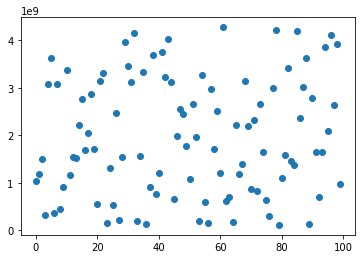

In [10]:
# Newman's lcg.py
from pylab import plot, show

N = 100
a = 1664525
c = 1013904223
m = 4294967296
x = 11
results = []

for i in range(N):
    x = (a*x+c) % m
    results.append(x)
plot(results, "o")
show()


Benefits: 

* good for testing code, since you can supply the same 'seed' (for reproducible outcome). e.g. the following code will always produce the same `x` (that is, 0.03738057695923325).

    `random.seed(4219)`
    
    `x = random.random()`
    
    * *This is actually true for most PRNGs, not just this linear congruential*
    * *The basic default behaviour of PRNGs is to rescale results over $[0, 1)$, hence the non-integer value for `x` above.*

* easy to generate many different sequences, just pick many different seeds.


## Randoms in python

Better methods?

* We want to avoid correlations between pairs of numbers
* Can do lots of test to show if PRNGs producing right "statistics" of random numbers!
* Python uses a Mersenne twister

Functions in `random.py` most likely to use (assuming `import random`):

* `random()`: gives a random float uniformly distributed in a the range $[0, 1)$ (all values have equal probability of being selected),
* `randrange(m, n)`: Gives a random integer from `m` to `n-1`, inclusive.
* If you need a uniformly distributed random float outside the range $[0,1)$, say in range $[a,b)$, then just multiply your answer by $(b-a)$ and shift the argument. For example:

    `num = random()`

    `shiftnum = (b-a)*num + a`

More resources (**you may find useful for lab!**):

https://numpy.org/doc/stable/reference/random/index.html

https://docs.python.org/3/library/random.html

## Random sampling from non-uniform distributions

What if you need a random number from a non-uniform distribution?

* Get a uniformly distributed random number, then use a transformation to make it seem like it comes from a non-uniform distribution.
* Consider source of random floats $z$ from a distribution with probability density function $q(z)$, i.e., the probability of generating a number in the interval $z$ to $z+\text dz$ is:
$$q(z)\text dz$$
* For a uniform distribution over $[0, 1)$, $q(z)=1$ because for all d$z$, equal probability of number being chosen.


* Now consider transformation of $z$ into new variable, say $x$, using:
    $$x=x(z)$$
* Then $x$ is also a random number but will have some other probability distribution, call it $p(x)$.
* The probability of generating a value of $x$ between $x$ and $x+\text dx$ is by definition equal to the probability of generating a value of $z$ between the corresponding $z$ and $z + \text dz$:
    $$p(x) \text dx = q(z) \text dz, \quad \text{where}\ x=x(z)$$


* Goal: find a function $x(z)$ so that $x$ has the distribution we want.
* Then we can use `random()` to get a uniformly distributed random number $z$ and transform it to $x$ using:
    $$q(z) = 1 \quad \text{over}\quad [0,1)$$
    $$q(z)\text dz = p(x)\text d x$$
    $$\Rightarrow \int_0^z 1 \text d z' = z = \int_0^{x(z)} p(x')\text d x'.$$
* Plug in your $p(x)$ for the probability distribution you need and integrate to find $z(x)$ (if you can!)
* Even then: might not be possible to solve for $x(z)$.

**Example: exponential distribution**
$$q(z) = 1 \quad \text{over}\quad [0,1)$$
$$p(x) = a\exp(-a x)  \quad \text{over}\quad [0,\infty)$$
$$\Rightarrow\ z = \int_0^{x(z)}a\exp(-ax')\text d x' = 1 - \exp(-ax)$$
$$\Rightarrow\ x = -\frac{\ln(1-z)}a.$$

* Draw a number $z$ in $[0,1)$,
* $x(z)$ has the desired distribution.

# Intro to "Monte Carlo Integration"

Uses random numbers to pick points at which to evaluate integrand.

Sounds great in theory. Would never work in practice without computers!

## Why use it?

You've already learned a bunch of different methods for integrating, why introduce another one?  (Especially since its convergence/error properties are worse than the other methods):

**Reason 1: Good for pathological functions**
Or just fast-varying functions. 


**Reason 2: MUCH faster for multi-dimensional integrals.**, i.e. deals with the "curse of dimensionality":

* For a dimension-$d$ integral, you need $O(n^d)$ grid points.
  * E.g. with trapezoid, Simpson or Gaussian integration: for $n=10$ points along one axis, a $10$-$d$ integral need $10^{10}$ grid points!
* Alternative way to look at it: if you can afford $N$ points, your grid has side length $O(N^{1/d})$.
    * For trapezoid integration, error $\epsilon = O(h^2) \propto 1/N^{2/d}$.
    * E.g., for a 10-$d$ integral, $\epsilon \propto 1/N^{1/5}$.
    * **Monte Carlo:** $\boxed{\epsilon \propto 1/N^{1/2}}$**, regardless of $d$.**

**Reason 3: much easier to implement in complicated domains**
i.e., complicated boundaries of integration.
* Simple and flexible.
* Can "tune" it to focus on important parts.

## Implementation of Monte Carlo integration

* We will cover 3 techniques:
    * "hit or miss" or "standard" Monte Carlo
    * "mean value" Monte Carlo
    * "importance sampling" Monte Carlo	

![MCimplementation](MC_implementation.png)

### Hit-or-miss MC

* If your function "fits" in a finite region where we want to integrate from $x=0$ to $x=2$:
$$f(x) = \sin^2\left[\frac{1}{(2-x)x}\right]$$
* function fits in box of height 1, width 2. 
* Define area of box: $A$ ($=2$ here; *this is important! It is the piece of info we will leverage*).
* Integral of function is shaded area in the box  (call it $I$).

![NewmanFig10-4](fig10-4.png)

* Probability that your random point falls in the shaded region is $p = I/A$.
* Algorithm:
    1. Randomly pick $N$ locations $(x, y)$ in the box (lots of them).
    2. Count the number of locations that are in the shaded region (call the count $k$).
    3. The fraction of points in the shaded region is $k/N$. This approximates the probability $p$.
Solve for $I$:
$$P = \frac{I}{A} \approx \frac{k}N\ \Rightarrow\ I\approx \frac{kA}{N}.$$

**Error estimate on the integral** (text gives derivation on page 467 from probability theory):

* The *Expected Error* (standard deviation):
$$\sigma = \sqrt{\frac{(A-I)I}{N}}.$$
* Notice it varies as $N^{-1/2}$. This is **very slow**!
* Compare:
    * Trapezoid Rule: error varies as $N^{-2}$,
	* Simpson's Rule: error varies as $N^{-4}$.
* This is why you only use Monte Carlo integration if you absolutely have to.

### Mean value MC

* Use the definition of an average (or mean value):
$$I = \int_a^b f(x)\text d x,$$
$$\left<f\right> = \frac1{b-a}\int_a^b f(x) \text d x = \frac{I}{b-a}$$
$$\Rightarrow\ I = (b-a)\left<f\right>$$
* Use random numbers for $x$ to estimate $\left<f\right>$. Evaluate $f$ at $N$ random $x$'s, then calculate:
$$\left<f\right>\approx\frac1N\sum_{i=1}^N f(x_i) \ \Rightarrow \ I\approx \frac{b-a}{N}\sum_{i=1}^N f(x_i).$$
* Different from "hit-or-miss": back then we chose $N$ random points over $(x, y)$ instead of just $x$ here.

**Error estimate** (textbook obtains expected error from probability theory):
$$\sigma = (b-a)\sqrt{\frac{\text{var} f}N}$$
$$\text{var} f = \left<f^2\right> - \left< f \right>^2.$$
* Notice it also varies as $N^{-1/2}$.
    However, it turns out the leading constant is smaller than with the hit or miss method. (We won't go into the mathematical details of why.)

### Importance sampling MC

* Good to use when your integrand contains a divergence
* Want to place more points in region where the integrand is large to better estimate the integral
* When you want to integrate out to infinity, give less weight to points in densely-populated regions to not bias final result
* Illustrative example (obviously a silly one for Monte-Carlo, but good for making my point):
$$f(x) = 1\quad \text{for}\quad c<x<d, \qquad f(x) = 0\quad \text{otherwise}.$$

Text(0, 0.5, '$f$')

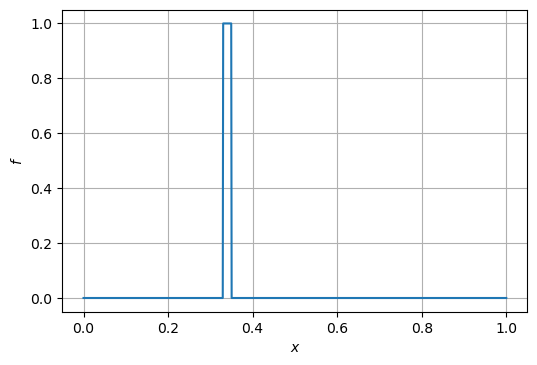

In [ ]:
import matplotlib.pyplot as plt
x = np.linspace(0, 1, 1000)
f = 0.*x

c = 0.33
d = 0.35
for i, xs in enumerate(x):
    if c < xs < d:
        f[i] = 1.
        
plt.figure(dpi=100)
plt.plot(x, f)
plt.grid()
plt.xlabel('$x$')
plt.ylabel('$f$')

* As $c$ and $d$ get closer to each other, it becomes easier and easier to 'miss' the region between $c$ and $d$ with uniformly sampled points
* evaluating the integral many times using Mean Value or Hit/Miss MC (with different randomly sampled points) can give very different answers, much larger than the expected error
* Solution: sample "important" regions more frequently.
    I.e., come up with a non-uniformly distributed set of random numbers.
    This is called "Importance Sampling".

* Text (p. 473) shows that using a weight function $w(x)$, you can always write:
$$I = \int_a^b f(x)\text d x = \underbrace{\left<\frac{f(x)}{w(x)}\right>_w}_{weighted\\ average}\int_a^b w(x)\text d x.$$

* Weighted average: $\left<X\right>_w =$ average of $X$ over set of points that sample "heavily-weighted" region more frequently, following $w$.
    * But then, $\left<f/w\right>_w$ means that the more we sample a region, the less weight points in that region have in the final average.

* Goal: find a weight function that gets rid of pathologies in integrand $f(x)$.
    E.g., if $f(x)$ has a divergence, factor the divergence out and hence get a sum (in the $\left<\right>$) that is well behaved (i.e. doesn't vary much each time you do the integral).

**Example:**
$$I = \int_0^1 \frac{x^{-1/2}}{1 + \exp(x)}\text d x,$$
diverges as $x\to 0$ because of numerator.

* Fine, let $w(x)= numerator$.
    Then
    $$\left<\frac{f(x)}{w(x)}\right>_w = \frac1N \sum_{i=1}^{N}\frac{f(x_i)}{w(x_i)} = \frac1N \sum_{i=1}^{N}\frac{1}{1 + \exp(x_i)},$$
    which is much better behaved than 
    $$\left<f(x)\right> = \frac1N \sum_{i=1}^{N}\frac{x^{-1/2}}{1 + \exp(x_i)}.$$

* $\left<\right>_w$ isn't $\left<\right>$: it is a *weighted* average, numbers aren't drawn uniformly in $[0, 1)$.
    The *weights* define how often you draw a sample
* In practice: when you've chosen your weight function, you then need to make sure to randomly sample points from the non-uniform distribution:
    $$p(x) = \frac{w(x)}{\int_a^b w(x)\text d x}$$
    Use the transformation method described earlier in this lecture to take a uniformly distribution random $z$ and find the corresponding $x$ for this distribution. 

**Error estimate:**
    $$\sigma = \sqrt{\frac{\text{var}(f/w)}{N}}\int_a^b w(x)\text d x.$$
    Yes, it also varies as $N^{-1/2}$.   If you do the integral many times, your values should mostly fall within the expected error.
